## Simulator to run Markov Prediction over some datasets

In [1]:
import os
import numpy as np
import pandas as pd
from main.utils.predictor import TransitionMatrix, MarkovChainPredictor, min_max_scaler, States
from predict.settings import DATASET_DIR
import matplotlib.pyplot as plt

In [2]:
def read_data(data):
    return pd.read_csv(os.path.join(DATASET_DIR, f"{data}.csv"))

In [3]:
data = read_data("flood_test")    

In [4]:
data.describe()

,rainfall,waterlevel
count,109197.000000,109197.000000
mean,0.017960,0.743541
std,0.227231,0.599465
min,0.000000,0.000000
25%,0.000000,0.390000
50%,0.000000,0.550000
75%,0.000000,0.880000
max,14.200000,8.370000


In [5]:
data["WaterLevel"] = data["waterlevel"]

In [6]:
data["WaterLevel"].values.shape

(109197,)

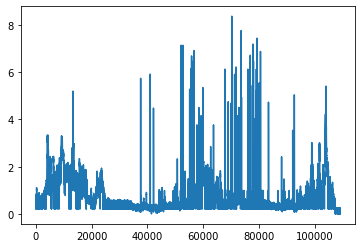

In [7]:
plt.plot(data["WaterLevel"])

In [8]:
max_height=2.0

In [9]:
def split_test_train(data):
    length = data.shape[0]
    test = int(length * 0.8)
    test_data = data[:test]
    train_data = data[test:]
    return pd.DataFrame({'WaterLevel': test_data}), pd.DataFrame({'WaterLevel': train_data})

In [10]:
train_data, test_data = split_test_train(data["WaterLevel"].values)

In [11]:
transition_matrix = TransitionMatrix(train_data, max_height=max_height)

In [12]:
transition_matrix.generate()

array([[9.94290279e-01, 4.81921400e-03, 8.90506934e-04],
       [5.24822695e-02, 9.22411348e-01, 2.51063830e-02],
       [1.67300380e-02, 4.53738910e-02, 9.37896071e-01]])

In [13]:
pd.DataFrame(transition_matrix.transitions)

,normal,almost_flooded,flooded
normal,75925,368,68
almost_flooded,370,6503,177
flooded,66,179,3700


In [14]:
current_state = States.get_state(train_data["WaterLevel"].values[-1])

In [15]:
predictor = MarkovChainPredictor(transition_matrix.values, transition_matrix.states)
no_predictions = len(test_data)

In [16]:
predictor.next_state(current_state)

'normal'

In [17]:
predictions = predictor.generate_states(current_state, no_predictions=no_predictions)

In [18]:
test_data["WaterLevel"] = min_max_scaler(test_data["WaterLevel"].values, max_height)
test_data['state'] = States.get_states(test_data["WaterLevel"], type="names")

In [19]:
difference = pd.DataFrame({"Prediction": predictions, "Actual_state": test_data["state"][:no_predictions]})

In [20]:
difference.query('Prediction != Actual_state').shape

(2242, 2)

In [21]:
difference

,Prediction,Actual_state
0,normal,normal
1,normal,normal
2,normal,normal
3,normal,normal
4,normal,normal
...,...,...
21835,normal,normal
21836,normal,normal
21837,normal,normal
21838,normal,normal


In [22]:
accuracy = (difference.shape[0] - difference.query('Prediction != Actual_state').shape[0])/difference.shape[0]

In [23]:
accuracy

0.8973443223443224

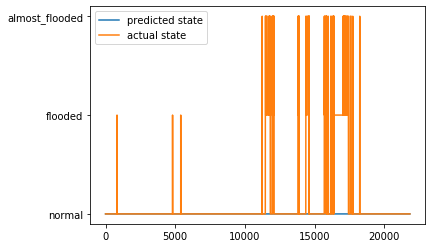

In [24]:
fig, ax = plt.subplots()
ax.plot(difference['Prediction'], label="predicted state")
ax.plot(difference['Actual_state'], label="actual state")
ax.legend()
plt.show()